## Importing neccessary liberaries

In [10]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization

from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import cv2
from tensorflow.keras.utils import img_to_array

___________________________________________________________________________________________
## Seting image size, batch size and number of emotions (classes)

In [11]:
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 32
NUM_CLASSES = 7

## Preparing ImageDataGenerator with the image augmentations needed:
rescaling,horizontal flip and rotation

In [12]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,
                                 rotation_range=15,
                                 fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255.)

_____________________________________________________________________________________________
## Importing the images from directories using the previously inisialized Image Data Generators

In [13]:


old_train_set=train_datagen.flow_from_directory('Datasets/fer_ckplus_kdef/train',
                                               target_size=IMAGE_SIZE,
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               color_mode = "grayscale")

old_test_set=test_datagen.flow_from_directory('Datasets/fer_ckplus_kdef/test',
                                             target_size=IMAGE_SIZE,
                                             class_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             shuffle=True,
                                             color_mode = "grayscale")

Found 24041 images belonging to 7 classes.
Found 8014 images belonging to 7 classes.


## Ploting the distribution of the original dataset 

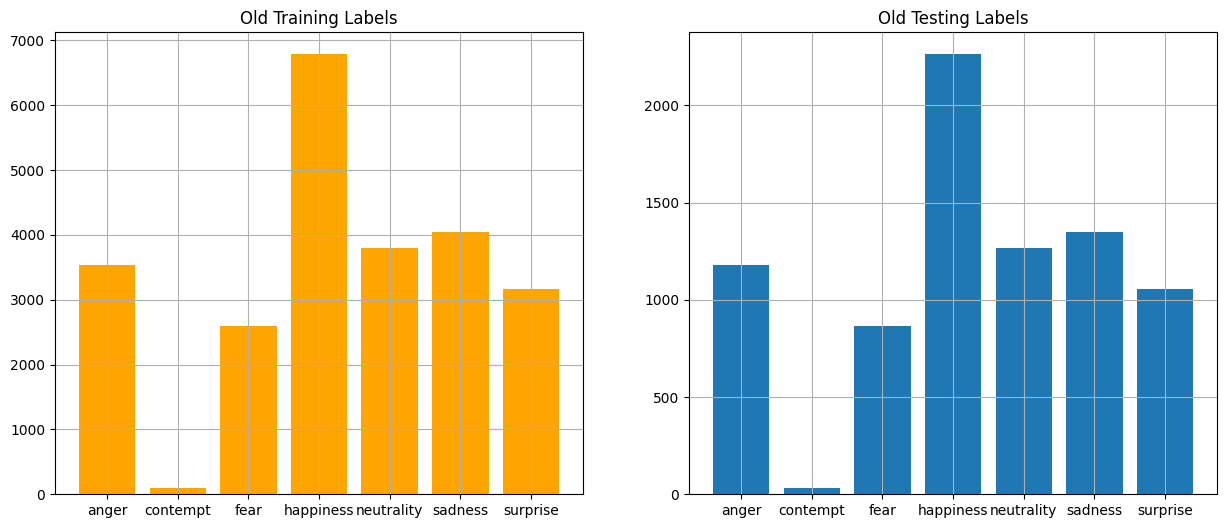

In [14]:

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1
    df_array2['emotion'] = array2
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=False)
    x = emotions.keys()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.values()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.values()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()
    
emotions=old_test_set.class_indices 
plot_compare_distributions(old_train_set.classes, old_test_set.classes, title1='Old Training Labels', title2='Old Testing Labels')

## Importing images from the dataset AffectNet-HQ to balance the distribution better in  FER_CK_KDEF dataset (the used dataset for this project)

In [15]:
import os 
from PIL import Image
root='Datasets/AffectNet-HQ/contempt'
images= os.listdir(root)
test_ratio = 0.20
train_FileNames, test_FileNames = np.split(np.array(images),[int(len(images)* (1 - test_ratio))])
for im in train_FileNames:
    img = Image.open(root+'/'+im).convert('L')
    img=img.resize((224,224))
    img.save('Datasets/fer_ckplus_kdef/train/contempt/'+im)
    
for im in test_FileNames:
    img = Image.open(root+'/'+im).convert('L')
    img=img.resize((224,224))
    img.save('Datasets/fer_ckplus_kdef/test/contempt/'+im)

## Importing the newly balanced dataset

In [18]:


training_set=train_datagen.flow_from_directory('Datasets/fer_ckplus_kdef/train',
                                               target_size=IMAGE_SIZE,
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               color_mode = "grayscale")

testing_set=test_datagen.flow_from_directory('Datasets/fer_ckplus_kdef/test',
                                             target_size=IMAGE_SIZE,
                                             class_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             shuffle=True,
                                             color_mode = "grayscale")

Found 26584 images belonging to 7 classes.
Found 8650 images belonging to 7 classes.


## Plotting the new distribution

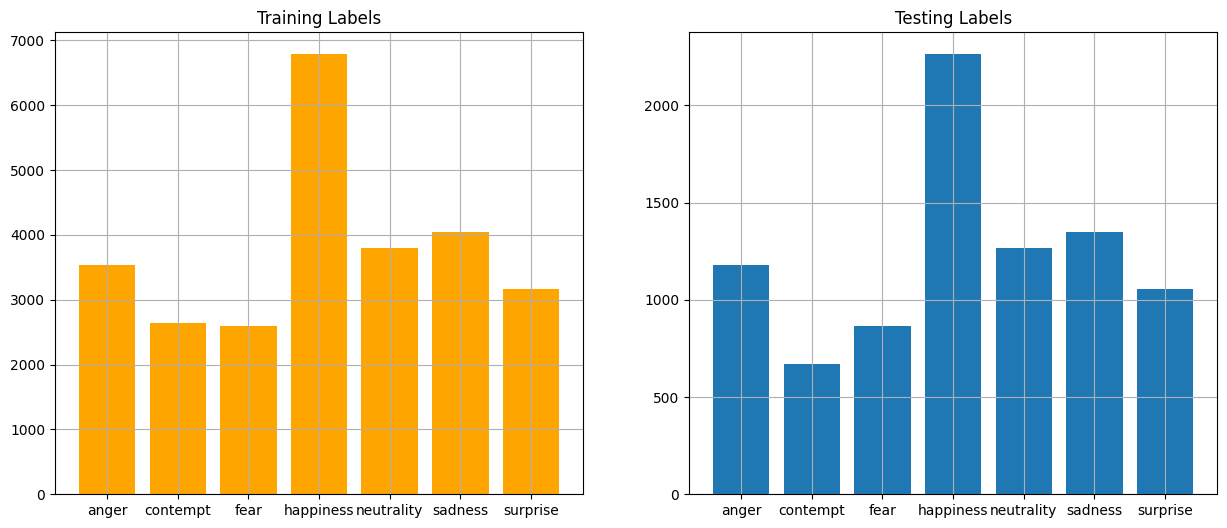

In [19]:
plot_compare_distributions(training_set.classes, testing_set.classes, title1='Training Labels', title2='Testing Labels')

__________________________________________________________________________
## Ploting images samples with their corrosponding classification

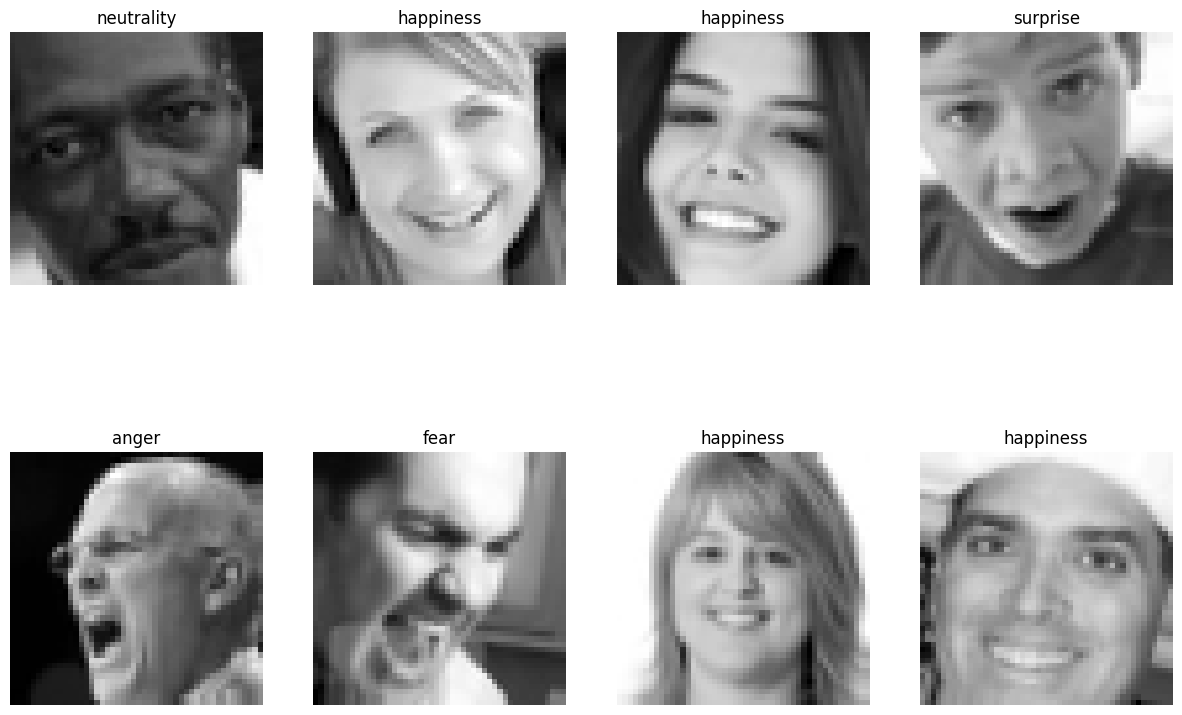

In [18]:
x,y=next(training_set)

classes_names=list(training_set.class_indices.keys())

def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(img[i], cmap='gray')
        plt.title(classes_names[np.argmax(labels[i])])
        plt.axis('off')
plot_images(x,y)

_______________________________________________________________________________________________
## Building the model 
<ol>
  <li>Inisialize the model with type Sequential</li>
  <li>Add Conv2D layer with 64 filters(kernels) each kernel has a size of (3, 3)since the image size is fairly small </li>
  <li>Add a BatchNormalization layer to re-center and re-scale the input</li>
  <li>Add a max MaxPooling2D with pool size (2,2)</li>

  <li>Add Conv2D layer again with 128 filters this time each filter has a size of (3, 3)</li>
  <li>Add a Dropout layer to counteract overfitting which will randomly turn off .3 of the neurons with each epoch </li>  
  <li>Add a BatchNormalization layer again</li>
  <li>Add a max MaxPooling2D with pool size (2,2)</li>

  <li>Add Conv2D layer with 256 filters(kernels) each kernel has a size of (3, 3)since the image size is fairly small </li>
  <li>Add a BatchNormalization layer </li>
  <li>Add a max MaxPooling2D with pool size (2,2)</li>
    
  <li>Add Conv2D layer with 256 filters(kernels) each kernel has a size of (3, 3)since the image size is fairly small </li>
  <li>Add a BatchNormalization layer </li>
  <li>Add a max MaxPooling2D with pool size (2,2)</li>

  <li>Flatten the output from the last Conv2D (turn it to 1D sequence) to prepare it to be fed into the next layer </li>
    
  <li>Add a Dense layer (fully connected) with 128 neurons </li>
  <li>Add a Dropout layer with 0.25 ratio </li>  
  <li>Add a BatchNormalization layer </li>

  <li>Add a Dense layer (fully connected) with 64 neurons </li>
  <li>Add a BatchNormalization layer </li>

  <li>Add a Dense layer with softmax activation function (since we are trying to do multiclass classification) with a neurone for each class (NUM_CLASSES) which is 7 in this case </li>
</ol>

In [6]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(NUM_CLASSES,activation='softmax'))




_______________________________________________________________________________________________
## Add an early stopping to restore best weights and stop the training if the accuracy stopped improving after 10 epochs

In [ ]:
model.compile(loss='categorical_crossentropy',
            optimizer=Adam(1e-3),
            metrics=['accuracy'])


____________________________________________________________________________________________
## Add an early stopping to restore best weights and stop the training if the accuracy stopped improving after 10 epochs

In [7]:
early = tf.keras.callbacks.EarlyStopping( patience=5,
                                          min_delta=0.001,
                                          restore_best_weights=True,
                                          verbose=1)

__________________________________________________________________________________________
## Fiting (training) the model and saving the history for further analysis 

In [8]:
history = model.fit(training_set,
                    validation_data=testing_set,
                    epochs=20,
                    batch_size=BATCH_SIZE,
                    callbacks=[early])

Epoch 1/20
805/805 [==============================] - 505s 620ms/step - loss: 1.6214 - accuracy: 0.3873 - val_loss: 4.7265 - val_accuracy: 0.0702
Epoch 2/20
805/805 [==============================] - 401s 498ms/step - loss: 1.2632 - accuracy: 0.5238 - val_loss: 1.2644 - val_accuracy: 0.5268
Epoch 3/20
805/805 [==============================] - 476s 591ms/step - loss: 1.1255 - accuracy: 0.5781 - val_loss: 1.2011 - val_accuracy: 0.5522
Epoch 4/20
805/805 [==============================] - 477s 592ms/step - loss: 1.0472 - accuracy: 0.6107 - val_loss: 1.2351 - val_accuracy: 0.5431
Epoch 5/20
805/805 [==============================] - 514s 639ms/step - loss: 0.9989 - accuracy: 0.6321 - val_loss: 1.0487 - val_accuracy: 0.6103
Epoch 6/20
805/805 [==============================] - 499s 620ms/step - loss: 0.9487 - accuracy: 0.6484 - val_loss: 1.0295 - val_accuracy: 0.6250
Epoch 7/20
805/805 [==============================] - 459s 570ms/step - loss: 0.9213 - accuracy: 0.6594 - val_loss: 1.0306 -

________________________________________________________________________________
## Plot Training and Validation accurarcy diagram

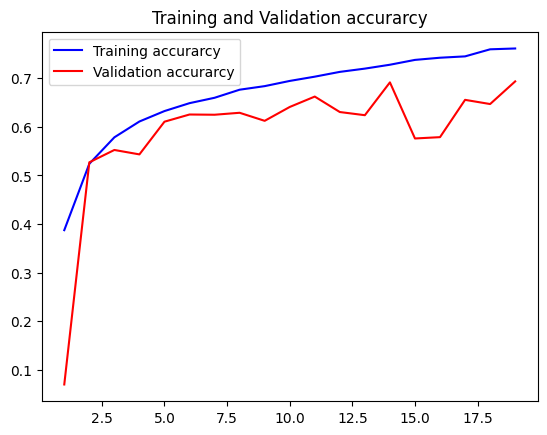

<Figure size 640x480 with 0 Axes>

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
plt.show()

___________________________________________________________________________________________
## Confusion matrix
producing the confusion matrix by predicting the validation set batch by batch and appending the results to an empty numpy array 


accuracy: 69.11%


C:\Users\ahmad\AppData\Local\Temp\ipykernel_9508\2704387167.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


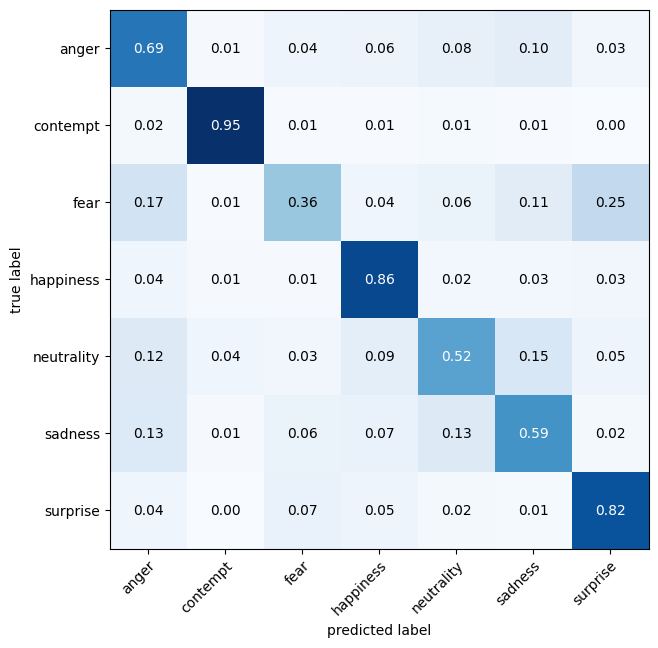

In [16]:
scores = model.evaluate(testing_set, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

classes_names=list(testing_set.class_indices.keys())

y_pred=np.empty((BATCH_SIZE,))
y_true=np.empty((BATCH_SIZE,))
for i in range(len(testing_set)):
    y_pred_temp = model.predict(testing_set[i][0], verbose=0)
    y_pred_temp = np.array([np.argmax(x) for x in y_pred_temp])
    y_pred=np.append(y_pred,y_pred_temp)
    y_true_temp=np.array([np.argmax(x) for x in testing_set[i][1]])
    y_true=np.append(y_true,y_true_temp) 
cm = confusion_matrix(y_true[BATCH_SIZE:], y_pred[BATCH_SIZE:])



fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                show_absolute=False,
                                class_names=classes_names,
                                figsize=(NUM_CLASSES, NUM_CLASSES))
fig.show()

___________________________________________________________________________________________
## Extract faces from an image and applying the model to predict the emotions 

Number of detected faces: 3
1/1 [==============================] - 0s 49ms/step


(-0.5, 310.5, 191.5, -0.5)

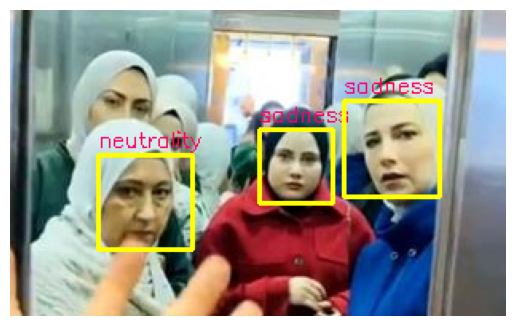

In [12]:
# read the input image
img = cv2.imread('aya.jpg')

# convert to grayscale of each frames
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# read haacascade to detect faces in input image
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

# detects faces in the input image
faces = face_cascade.detectMultiScale(gray, 1.1, 2)
print('Number of detected faces:', len(faces))
# loop over all the detected faces

for (x,y,w,h) in faces:
   fc = gray[y:y+h, x:x+w]
   roi = cv2.resize(fc, IMAGE_SIZE)
   roi = img_to_array(roi)  # Transforming image to array
   roi = roi / 255  # Normalizing Image
   roi = np.expand_dims(roi, axis=0)
   pred_im = model.predict(roi)
   text_idx=np.argmax(pred_im)
   text=classes_names[text_idx]
   cv2.putText(img, text, (x, y-5),
       cv2.FONT_HERSHEY_SIMPLEX, 0.45, (100, 0, 255), 1)
   # To draw a rectangle around the detected face  
   cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)

# Display the image 
plt.imshow(img[:,:,::-1])
plt.axis('off')